Лабораторная работа №2

## Логистическая и линейная регрессия

## 2. Создание бейзлайна и оценка качества

В этом разделе мы создадим базовые модели логистической регрессии для классификации и линейной регрессии для предсказания прочности бетона.

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, mean_squared_error, mean_absolute_error, r2_score, 
    classification_report, precision_recall_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

In [2]:
# Загрузка данных
df_water = pd.read_csv('water_potability.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'], index_col=0)
df_concrete = pd.read_csv('concrete.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'])

print(f"Размер данных (вода): {df_water.shape}")
print(f"Размер данных (бетон): {df_concrete.shape}")

Размер данных (вода): (3276, 10)
Размер данных (бетон): (1030, 9)


### 2a. Подготовка данных и обучение baseline моделей

In [3]:
# Удаление пропусков для простого baseline
df_water_clean = df_water.dropna()
df_concrete_clean = df_concrete.dropna()

# Разделение на признаки и целевую переменную
X_water = df_water_clean.drop('Potability', axis=1)
y_water = df_water_clean['Potability']

X_concrete = df_concrete_clean.iloc[:, :-1]
y_concrete = df_concrete_clean.iloc[:, -1]

# Разделение на обучающую и тестовую выборки
X_train_water, X_test_water, y_train_water, y_test_water = train_test_split(
    X_water, y_water, test_size=0.3, random_state=42
)

X_train_concrete, X_test_concrete, y_train_concrete, y_test_concrete = train_test_split(
    X_concrete, y_concrete, test_size=0.3, random_state=42
)

print(f"Классификация - тренировочная: {X_train_water.shape}, тестовая: {X_test_water.shape}")
print(f"Регрессия - тренировочная: {X_train_concrete.shape}, тестовая: {X_test_concrete.shape}")

Классификация - тренировочная: (1407, 9), тестовая: (604, 9)
Регрессия - тренировочная: (721, 8), тестовая: (309, 8)


Обучим модели регрессии без качественной предобработки данных. Удалим только пропуски, чтобы модель не выдавала ошибку.

In [4]:
# обуение логистической регрессии для классификации
lr_clf_baseline = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_clf_baseline.fit(X_train_water, y_train_water)
y_pred_water_baseline = lr_clf_baseline.predict(X_test_water)
y_pred_proba_water_baseline = lr_clf_baseline.predict_proba(X_test_water)[:, 1]

# обучение линейной регрессии
lin_reg_baseline = LinearRegression()
lin_reg_baseline.fit(X_train_concrete, y_train_concrete)
y_pred_concrete_baseline = lin_reg_baseline.predict(X_test_concrete)


### 2b. Оценка качества моделей

Выведим и проанализируем метрики для модели классфикации.

Метрики качества (Логистическая регрессия - baseline):
  Accuracy:  0.4603
  Precision: 0.3785
  Recall:    0.4819
  F1-score:  0.4240
  ROC-AUC:   0.4868
  PR-AUC:    0.4505

Матрица ошибок:


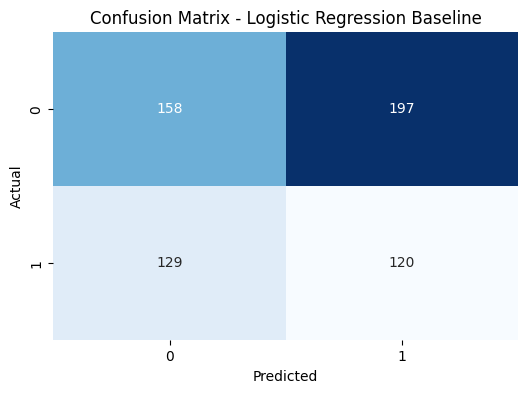


Отчет о классификации:
              precision    recall  f1-score   support

           0       0.55      0.45      0.49       355
           1       0.38      0.48      0.42       249

    accuracy                           0.46       604
   macro avg       0.46      0.46      0.46       604
weighted avg       0.48      0.46      0.46       604



In [5]:
accuracy = accuracy_score(y_test_water, y_pred_water_baseline)
precision = precision_score(y_test_water, y_pred_water_baseline, zero_division=0)
recall = recall_score(y_test_water, y_pred_water_baseline, zero_division=0)
f1 = f1_score(y_test_water, y_pred_water_baseline, zero_division=0)
roc_auc = roc_auc_score(y_test_water, y_pred_proba_water_baseline)
pr_curve = precision_recall_curve(y_test_water, y_pred_proba_water_baseline)
pr_auc = auc(pr_curve[1], pr_curve[0])
cm = confusion_matrix(y_test_water, y_pred_water_baseline)

print(f"Метрики качества (Логистическая регрессия - baseline):")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")
print(f"  PR-AUC:    {pr_auc:.4f}")

print(f"\nМатрица ошибок:")
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression Baseline')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"\nОтчет о классификации:")
print(classification_report(y_test_water, y_pred_water_baseline))

*Получили достаточно низкие значения метрик для модели классификации. Метрики выше, чем у модели KNN с аналогичной предобработкой данных. Пока модель сильно ошибается при классификации пригодной воды.*

#### Оценка качества модели линейной регрессии

In [6]:
mse = mean_squared_error(y_test_concrete, y_pred_concrete_baseline)
mae = mean_absolute_error(y_test_concrete, y_pred_concrete_baseline)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_concrete, y_pred_concrete_baseline)

print(f"Метрики качества (Линейная регрессия - baseline):")
print(f"  MSE:  {mse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²:   {r2:.4f}")

Метрики качества (Линейная регрессия - baseline):
  MSE:  109.7508
  MAE:  8.2986
  RMSE: 10.4762
  R²:   0.5944


*Пока метрики сильно хуже, чем у KNN. Модель дает ошибку предсказания. MSE достаточно высокий.*

#### Визуализация результатов baseline моделей

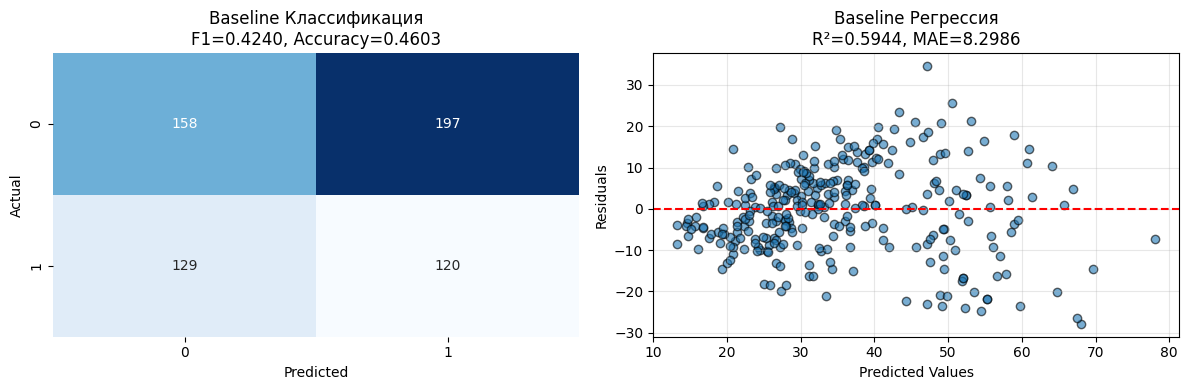

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Матрица ошибок для классификации
cm_baseline_clf = confusion_matrix(y_test_water, y_pred_water_baseline)
sns.heatmap(cm_baseline_clf, annot=True, fmt='d', ax=axes[0], cmap='Blues', cbar=False)
axes[0].set_title(f'Baseline Классификация\nF1={f1:.4f}, Accuracy={accuracy:.4f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# График остатков для регрессии
residuals_baseline_reg = y_test_concrete - y_pred_concrete_baseline
axes[1].scatter(y_pred_concrete_baseline, residuals_baseline_reg, alpha=0.6, edgecolors='k')
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title(f'Baseline Регрессия\nR²={r2:.4f}, MAE={mae:.4f}')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Улучшение бейзлайна

### 3a. Формулирование гипотез улучшения

**Гипотеза 1:** Заполнение пропусков медианой улучшит качество моделей

**Гипотеза 2:** Стандартизация признаков улучшит качество моделей (важно для логистической и линейной регрессии)

**Гипотеза 3:** Подбор оптимального параметра регуляризации C для логистической регрессии улучшит результаты

**Гипотеза 4:** Удаление выбросов методом IQR улучшит качество модели, особенно для регрессии

### 3b. Проверка гипотез

#### Гипотеза 1: Заполнение пропусков медианой

Классификация (с заполнением пропусков):
  Accuracy:  0.5249
  F1-score:  0.4339
  ROC-AUC:   0.5302
  PR-AUC:    0.4331

Матрица ошибок:

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.64      0.55      0.59       617
           1       0.39      0.49      0.43       366

    accuracy                           0.52       983
   macro avg       0.52      0.52      0.51       983
weighted avg       0.55      0.52      0.53       983

Метрики качества (Логистическая регрессия - baseline):
  Accuracy:  0.4603
  Precision: 0.3785
  Recall:    0.4819
  F1-score:  0.4240
  ROC-AUC:   0.4868
  PR-AUC:    0.4505


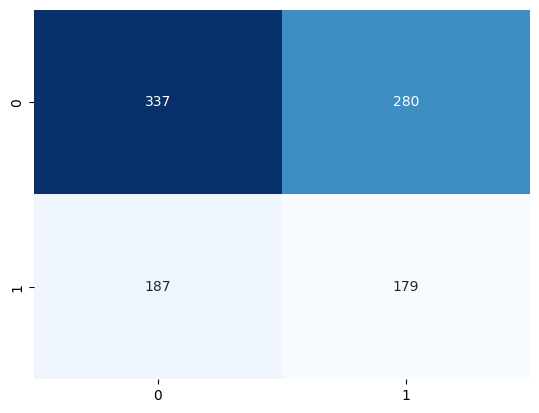

In [8]:
# Загрузка данных заново
df_water_hyp1 = pd.read_csv('water_potability.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'], index_col=0)

# Заполнение пропусков медианой по классам для классификации
df_water_hyp1['ph'] = df_water_hyp1.groupby('Potability')['ph'].transform(lambda x: x.fillna(x.median()))
df_water_hyp1['Sulfate'] = df_water_hyp1.groupby('Potability')['Sulfate'].transform(lambda x: x.fillna(x.median()))
df_water_hyp1['Trihalomethanes'] = df_water_hyp1.groupby('Potability')['Trihalomethanes'].transform(lambda x: x.fillna(x.median()))

# Разделение на признаки и целевую переменную
X_water_hyp1 = df_water_hyp1.drop('Potability', axis=1)
y_water_hyp1 = df_water_hyp1['Potability']

# Разделение на train/test
X_train_water_h1, X_test_water_h1, y_train_water_h1, y_test_water_h1 = train_test_split(
    X_water_hyp1, y_water_hyp1, test_size=0.3, random_state=42
)

# Обучение модели
# добавим балансировку классов для классификации
lr_clf_hyp1 = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_clf_hyp1.fit(X_train_water_h1, y_train_water_h1)
y_pred_water_h1 = lr_clf_hyp1.predict(X_test_water_h1)
y_pred_proba_water_h1 = lr_clf_hyp1.predict_proba(X_test_water_h1)[:, 1]

# Метрики для классификации
acc_h1 = accuracy_score(y_test_water_h1, y_pred_water_h1)
f1_h1 = f1_score(y_test_water_h1, y_pred_water_h1, zero_division=0)
roc_auc_h1 = roc_auc_score(y_test_water_h1, y_pred_proba_water_h1)
pr_curve_h1 = precision_recall_curve(y_test_water_h1, y_pred_proba_water_h1)
pr_auc_h1 = auc(pr_curve_h1[1], pr_curve_h1[0])

cm_hyp1 = confusion_matrix(y_test_water_h1, y_pred_water_h1)

print(f"Классификация (с заполнением пропусков):")
print(f"  Accuracy:  {acc_h1:.4f}")
print(f"  F1-score:  {f1_h1:.4f}")
print(f"  ROC-AUC:   {roc_auc_h1:.4f}")
print(f"  PR-AUC:    {pr_auc_h1:.4f}")

print(f"\nМатрица ошибок:")
sns.heatmap(cm_hyp1, annot=True, fmt='d', cmap='Blues', cbar=False)
print(f"\nОтчет о классификации:")
print(classification_report(y_test_water_h1, y_pred_water_h1))


print(f"Метрики качества (Логистическая регрессия - baseline):")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")
print(f"  PR-AUC:    {pr_auc:.4f}")

*Какие-то метрики стали хуже, какие-то лучше. Точнее PR-AUC сдала на несколько сотых лучше и accuracy тоже немного улучшилась. Но пока не значительно.*

In [9]:
df_concrete_hyp1 = pd.read_csv('concrete.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'])
# Заполнение пропусков для регрессии
df_concrete_hyp1 = df_concrete_hyp1.fillna(df_concrete_hyp1.median())

# отделяем признаки и целевую переменную
X_concrete_hyp1 = df_concrete_hyp1.iloc[:, :-1]
y_concrete_hyp1 = df_concrete_hyp1.iloc[:, -1]

# разделение на train/test
X_train_concrete_h1, X_test_concrete_h1, y_train_concrete_h1, y_test_concrete_h1 = train_test_split(
    X_concrete_hyp1, y_concrete_hyp1, test_size=0.3, random_state=42
)

# обучение модели линейной регрессии
lin_reg_hyp1 = LinearRegression()
lin_reg_hyp1.fit(X_train_concrete_h1, y_train_concrete_h1)
y_pred_concrete_h1 = lin_reg_hyp1.predict(X_test_concrete_h1)


# Метрики для регрессии
mae_h1 = mean_absolute_error(y_test_concrete_h1, y_pred_concrete_h1)
r2_h1 = r2_score(y_test_concrete_h1, y_pred_concrete_h1)
mse_h1 = mean_squared_error(y_test_concrete_h1, y_pred_concrete_h1)

print(f"\nРегрессия (с заполнением пропусков):")
print(f"  MAE:  {mae_h1:.4f}")
print(f"  R²:   {r2_h1:.4f}")
print(f"  MSE:  {mse_h1:.4f}")

print(f"Метрики качества (Линейная регрессия - baseline):")
print(f"  MSE:  {mse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  R²:   {r2:.4f}")


Регрессия (с заполнением пропусков):
  MAE:  8.2986
  R²:   0.5944
  MSE:  109.7508
Метрики качества (Линейная регрессия - baseline):
  MSE:  109.7508
  MAE:  8.2986
  RMSE: 10.4762
  R²:   0.5944


*Замена пропусков никак не повлияла на качество модели регрессии.*

#### Гипотеза 2: Стандартизация признаков

БЕЗ стандартизации: Accuracy=0.5249, F1=0.4339, ROC-AUC=0.5302, PR-AUC=0.4331
СО стандартизацией:  Accuracy=0.5198, F1=0.4434, ROC-AUC=0.5251, PR-AUC=0.4103

Регрессия БЕЗ стандартизации: MAE=8.2986, R²=0.5944, MSE=109.7508
Регрессия СО стандартизацией:  MAE=8.2986, R²=0.5944, MSE=109.7508


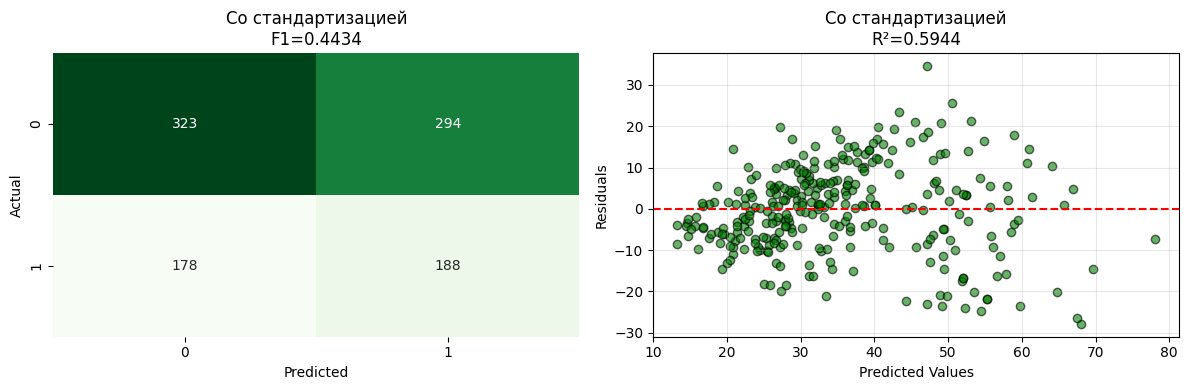

In [10]:
print(f"БЕЗ стандартизации: Accuracy={acc_h1:.4f}, F1={f1_h1:.4f}, ROC-AUC={roc_auc_h1:.4f}, PR-AUC={pr_auc_h1:.4f}")

# Применяем стандартизацию
scaler_water_h2 = StandardScaler()
X_train_water_h2 = scaler_water_h2.fit_transform(X_train_water_h1)
X_test_water_h2 = scaler_water_h2.transform(X_test_water_h1)

scaler_concrete_h2 = StandardScaler()
X_train_concrete_h2 = scaler_concrete_h2.fit_transform(X_train_concrete_h1)
X_test_concrete_h2 = scaler_concrete_h2.transform(X_test_concrete_h1)

# Обучение моделей со стандартизацией
lr_clf_hyp2 = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_clf_hyp2.fit(X_train_water_h2, y_train_water_h1)
y_pred_water_h2 = lr_clf_hyp2.predict(X_test_water_h2)
y_pred_proba_water_h2 = lr_clf_hyp2.predict_proba(X_test_water_h2)[:, 1]

lin_reg_hyp2 = LinearRegression()
lin_reg_hyp2.fit(X_train_concrete_h2, y_train_concrete_h1)
y_pred_concrete_h2 = lin_reg_hyp2.predict(X_test_concrete_h2)

# Метрики для классификации
acc_h2 = accuracy_score(y_test_water_h1, y_pred_water_h2)
f1_h2 = f1_score(y_test_water_h1, y_pred_water_h2, zero_division=0)
roc_auc_h2 = roc_auc_score(y_test_water_h1, y_pred_proba_water_h2)
pr_curve_h2 = precision_recall_curve(y_test_water_h1, y_pred_proba_water_h2)
pr_auc_h2 = auc(pr_curve_h2[1], pr_curve_h2[0])

# Метрики для регрессии
mae_h2 = mean_absolute_error(y_test_concrete_h1, y_pred_concrete_h2)
r2_h2 = r2_score(y_test_concrete_h1, y_pred_concrete_h2)
mse_h2 = mean_squared_error(y_test_concrete_h1, y_pred_concrete_h2)

print(f"СО стандартизацией:  Accuracy={acc_h2:.4f}, F1={f1_h2:.4f}, ROC-AUC={roc_auc_h2:.4f}, PR-AUC={pr_auc_h2:.4f}")

print(f"\nРегрессия БЕЗ стандартизации: MAE={mae_h1:.4f}, R²={r2_h1:.4f}, MSE={mse_h1:.4f}")
print(f"Регрессия СО стандартизацией:  MAE={mae_h2:.4f}, R²={r2_h2:.4f}, MSE={mse_h2:.4f}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Матрица ошибок для классификации
cm_h2 = confusion_matrix(y_test_water_h1, y_pred_water_h2)
sns.heatmap(cm_h2, annot=True, fmt='d', ax=axes[0], cmap='Greens', cbar=False)
axes[0].set_title(f'Со стандартизацией\nF1={f1_h2:.4f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# График остатков для регрессии
residuals_h2 = y_test_concrete_h1 - y_pred_concrete_h2
axes[1].scatter(y_pred_concrete_h2, residuals_h2, alpha=0.6, edgecolors='k', color='green')
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title(f'Со стандартизацией\nR²={r2_h2:.4f}')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

*Масшабировние (стандартизация) --- не дало улучшений качества моделей.*

#### Гипотеза 3: Подбор параметра регуляризации C

Оптимальное C: 1, CV F1-score: 0.4433
C=1.0 (по умолчанию): Accuracy=0.5198, F1=0.4434, ROC-AUC=0.5251
C=1 (оптимальное): Accuracy=0.5198, F1=0.4434, ROC-AUC=0.5251


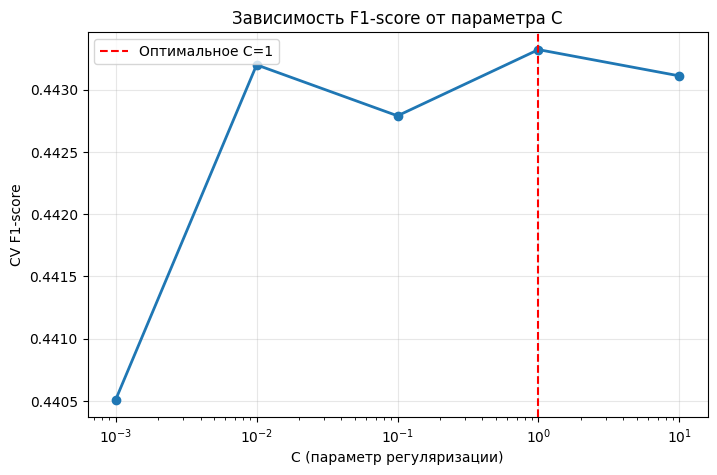

In [11]:
# Подбор оптимального параметра C для логистической регрессии
C_values = [0.001, 0.01, 0.1, 1, 10]
cv_scores_clf = []

for C in C_values:
    lr = LogisticRegression(C=C, random_state=42, max_iter=1000, class_weight='balanced')
    scores = cross_val_score(lr, X_train_water_h2, y_train_water_h1, cv=5, scoring='f1')
    cv_scores_clf.append(scores.mean())

best_C = C_values[np.argmax(cv_scores_clf)]
best_cv_score = max(cv_scores_clf)

print(f"Оптимальное C: {best_C}, CV F1-score: {best_cv_score:.4f}")

# Обучение с оптимальным C
lr_clf_hyp3 = LogisticRegression(C=best_C, random_state=42, max_iter=1000, class_weight='balanced')
lr_clf_hyp3.fit(X_train_water_h2, y_train_water_h1)
y_pred_water_h3 = lr_clf_hyp3.predict(X_test_water_h2)
y_pred_proba_water_h3 = lr_clf_hyp3.predict_proba(X_test_water_h2)[:, 1]

acc_h3 = accuracy_score(y_test_water_h1, y_pred_water_h3)
f1_h3 = f1_score(y_test_water_h1, y_pred_water_h3, zero_division=0)
roc_auc_h3 = roc_auc_score(y_test_water_h1, y_pred_proba_water_h3)
pr_curve_h3 = precision_recall_curve(y_test_water_h1, y_pred_proba_water_h3)
pr_auc_h3 = auc(pr_curve_h3[1], pr_curve_h3[0])

print(f"C=1.0 (по умолчанию): Accuracy={acc_h2:.4f}, F1={f1_h2:.4f}, ROC-AUC={roc_auc_h2:.4f}")
print(f"C={best_C} (оптимальное): Accuracy={acc_h3:.4f}, F1={f1_h3:.4f}, ROC-AUC={roc_auc_h3:.4f}")

# График зависимости F1 от C
plt.figure(figsize=(8, 5))
plt.plot(C_values, cv_scores_clf, marker='o', linewidth=2, markersize=6)
plt.xscale('log')
plt.axvline(x=best_C, color='r', linestyle='--', label=f'Оптимальное C={best_C}')
plt.xlabel('C (параметр регуляризации)')
plt.ylabel('CV F1-score')
plt.title('Зависимость F1-score от параметра C')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

*Подбор гиперпараметра C не дал значительных улучшений качества модели.*

#### Гипотеза 4: Удаление выбросов методом IQR

Регрессия - до удаления выбросов: (721, 8)
Регрессия - после удаления выбросов: (660, 8)

Регрессия БЕЗ удаления выбросов: MAE=8.2986, R²=0.5944, MSE=109.7508
Регрессия С удалением выбросов:  MAE=9.7056, R²=-0.1150, MSE=301.7036


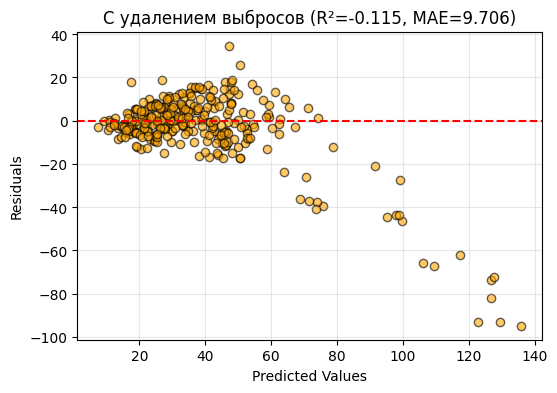

In [12]:
def remove_outliers_iqr(X: pd.DataFrame, y: pd.Series = None, factor: float = 1.5):
    """Удаляет строки, где хоть в одном числовом признаке значение выходит за пределы [Q1 - factor*IQR, Q3 + factor*IQR]."""
    numeric = X.select_dtypes(include=[np.number])
    Q1 = numeric.quantile(0.25)
    Q3 = numeric.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    mask = ((numeric >= lower) & (numeric <= upper)).all(axis=1)
    X_clean = X.loc[mask].copy()
    if y is None:
        return X_clean, mask
    return X_clean, y.loc[mask].copy(), mask

# Удаление выбросов для регрессии
X_train_concrete_h4, y_train_concrete_h4, mask_c = remove_outliers_iqr(
    pd.DataFrame(X_train_concrete_h2, columns=X_concrete_hyp1.columns), 
    pd.Series(y_train_concrete_h1.values, index=range(len(y_train_concrete_h1))), 
    factor=1.5
)

print(f"Регрессия - до удаления выбросов: {X_train_concrete_h2.shape}")
print(f"Регрессия - после удаления выбросов: {X_train_concrete_h4.shape}")

# Обучение модели регрессии после удаления выбросов
lin_reg_hyp4 = LinearRegression()
lin_reg_hyp4.fit(X_train_concrete_h4, y_train_concrete_h4)
y_pred_concrete_h4 = lin_reg_hyp4.predict(X_test_concrete_h2)

mae_h4 = mean_absolute_error(y_test_concrete_h1, y_pred_concrete_h4)
r2_h4 = r2_score(y_test_concrete_h1, y_pred_concrete_h4)
mse_h4 = mean_squared_error(y_test_concrete_h1, y_pred_concrete_h4)

print(f"\nРегрессия БЕЗ удаления выбросов: MAE={mae_h2:.4f}, R²={r2_h2:.4f}, MSE={mse_h2:.4f}")
print(f"Регрессия С удалением выбросов:  MAE={mae_h4:.4f}, R²={r2_h4:.4f}, MSE={mse_h4:.4f}")

# Визуализация
plt.figure(figsize=(6, 4))
residuals_h4 = y_test_concrete_h1 - y_pred_concrete_h4
plt.scatter(y_pred_concrete_h4, residuals_h4, alpha=0.6, edgecolors='k', color='orange')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'С удалением выбросов (R²={r2_h4:.3f}, MAE={mae_h4:.3f})')
plt.grid(alpha=0.3)
plt.show()

*Удаление выбросов только ухудшило качество модели регрессии.*

Классификация - до удаления выбросов: (2293, 9)
Классификация - после удаления выбросов: (1856, 9)
Классификация (после удаления выбросов - логистическая регрессия):
  Accuracy:  0.5076
  F1-score:  0.4292
  ROC-AUC:   0.5097
  PR-AUC:    0.3806

Сравнение: до удаления (C=1) F1=0.4434, после удаления F1=0.4292


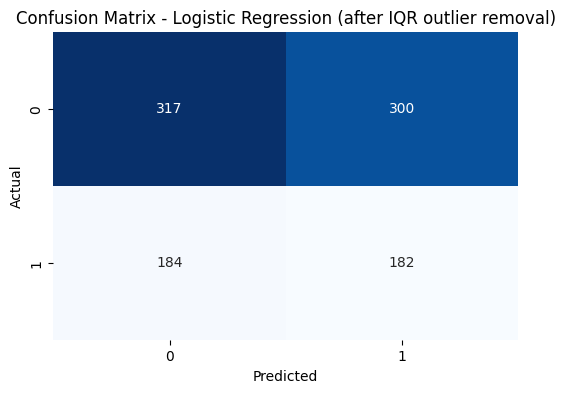

In [13]:
# Удаление выбросов для логистической регрессии (аналогично регрессии в cell 23)
# Преобразуем масштабированные трейновые признаки в DataFrame с корректными именами столбцов
df_train_water_scaled = pd.DataFrame(X_train_water_h2, columns=X_water_hyp1.columns)

# Приводим y к индексу 0..n-1, чтобы совпадал с маской внутри remove_outliers_iqr
y_train_water_indexed = pd.Series(y_train_water_h1.values, index=range(len(y_train_water_h1)))

# Удаляем выбросы методом IQR
X_train_water_h4, y_train_water_h4, mask_w = remove_outliers_iqr(df_train_water_scaled, y_train_water_indexed, factor=1.5)

print(f"Классификация - до удаления выбросов: {df_train_water_scaled.shape}")
print(f"Классификация - после удаления выбросов: {X_train_water_h4.shape}")

# Обучение логистической регрессии на очищенных данных (используем оптимальное C из подбора)
lr_clf_hyp4 = LogisticRegression(C=best_C, random_state=42, max_iter=1000, class_weight='balanced')
lr_clf_hyp4.fit(X_train_water_h4.values, y_train_water_h4)

# Оценка на тестовой выборке (масштабированной)
y_pred_water_h4 = lr_clf_hyp4.predict(X_test_water_h2)
y_pred_proba_water_h4 = lr_clf_hyp4.predict_proba(X_test_water_h2)[:, 1]

acc_h4 = accuracy_score(y_test_water_h1, y_pred_water_h4)
f1_h4 = f1_score(y_test_water_h1, y_pred_water_h4, zero_division=0)
roc_auc_h4 = roc_auc_score(y_test_water_h1, y_pred_proba_water_h4)
pr_curve_h4 = precision_recall_curve(y_test_water_h1, y_pred_proba_water_h4)
pr_auc_h4 = auc(pr_curve_h4[1], pr_curve_h4[0])

print("Классификация (после удаления выбросов - логистическая регрессия):")
print(f"  Accuracy:  {acc_h4:.4f}")
print(f"  F1-score:  {f1_h4:.4f}")
print(f"  ROC-AUC:   {roc_auc_h4:.4f}")
print(f"  PR-AUC:    {pr_auc_h4:.4f}")

# Сравнение с предыдущими результатами (до удаления выбросов)
print(f"\nСравнение: до удаления (C={best_C}) F1={f1_h3:.4f}, после удаления F1={f1_h4:.4f}")

# Визуализация матрицы ошибок
cm_h4 = confusion_matrix(y_test_water_h1, y_pred_water_h4)
plt.figure(figsize=(6,4))
sns.heatmap(cm_h4, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression (after IQR outlier removal)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

*Удаление выбросов только ухудшило качество модели классификации.*

### 3c-f. Формирование улучшенного бейзлайна

Выведем метрики для базовых и улучшенных моделей классификации и регрессии.

In [14]:
print("Метрики классификации:")
print(f"baseline:        Accuracy={accuracy:.4f}, F1={f1:.4f}, ROC-AUC={roc_auc:.4f}, PR-AUC={pr_auc:.4f}")
print(f"улучшенный: Accuracy={acc_h2:.4f}, F1={f1_h2:.4f}, ROC-AUC={roc_auc_h2:.4f}, PR-AUC={pr_auc_h2:.4f}")

print("\nМетрики регрессии:")
print(f"baseline:    MAE={mae:.4f}, R²={r2:.4f}, MSE={mse:.4f}")
print(f"улучшенный:  MAE={mae_h2:.4f}, R²={r2_h2:.4f}, MSE={mse_h2:.4f}")

Метрики классификации:
baseline:        Accuracy=0.4603, F1=0.4240, ROC-AUC=0.4868, PR-AUC=0.4505
улучшенный: Accuracy=0.5198, F1=0.4434, ROC-AUC=0.5251, PR-AUC=0.4103

Метрики регрессии:
baseline:    MAE=8.2986, R²=0.5944, MSE=109.7508
улучшенный:  MAE=8.2986, R²=0.5944, MSE=109.7508


### 3g. Выводы

Проанализировав различные гипотезы для улучшения качества моделей, можно сделать следующие выводы:

**Для логистической регрессии:**

После масштабирования признаков и заменой пропуском медианным значением, удалось добиться небольшого улучшения метрик модели классификации. Однако, подбор гиперпараметра C не дал значительных улучшений. И метрики остались на уровне baseline модели.

**Для линейной регрессии:**

После улучшений модель регресии не показала значительного улучшения. Попытка удалить выбросы только ухудшила качество модели.

Перед обучением моделей, необходимо выполнить препроцессинг данных: удалить пропуски или заменить их медианой или средним значением.

## 4. Имплементация алгоритмов логистической и линейной регрессии

### 4a. Реализация алгоритмов

#### Реализация логистической регрессии

In [28]:
class LogisticRegressionCustom:
    def __init__(self, learning_rate=0.01, n_iterations=1000, regularization=0.0,
                 tol=1e-6, fit_intercept=True, scale=False, class_weight=None, lr_decay=0.0):
        self.learning_rate = float(learning_rate)
        self.n_iterations = int(n_iterations)
        self.regularization = float(regularization)  # lambda
        self.tol = float(tol)
        self.fit_intercept = bool(fit_intercept)
        self.scale = bool(scale)
        self.class_weight = class_weight  # None, 'balanced' or dict {label: weight}
        self.lr_decay = float(lr_decay)
        self.coef_ = None
        self.intercept_ = 0.0
        self._weights = None
        self._x_mean = None
        self._x_std = None

    @staticmethod
    def _to_numpy(X):
        if hasattr(X, "values"):
            return X.values.astype(float)
        return np.asarray(X, dtype=float)

    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def _get_sample_weights(self, y):
        if self.class_weight is None:
            return None
        y = np.asarray(y).ravel()
        classes, counts = np.unique(y, return_counts=True)
        if self.class_weight == 'balanced':
            total = y.shape[0]
            weights = {c: total / (len(classes) * cnt) for c, cnt in zip(classes, counts)}
        elif isinstance(self.class_weight, dict):
            weights = self.class_weight
        else:
            return None
        return np.array([weights[val] for val in y], dtype=float)

    def fit(self, X, y):
        X_np = self._to_numpy(X)
        y_np = np.asarray(y).astype(float).ravel()

        # optional scaling (fit on train)
        if self.scale:
            self._x_mean = X_np.mean(axis=0)
            self._x_std = X_np.std(axis=0)
            self._x_std[self._x_std == 0.0] = 1.0
            X_np = (X_np - self._x_mean) / self._x_std

        n_samples, n_features = X_np.shape

        if self.fit_intercept:
            X_aug = np.hstack([np.ones((n_samples, 1)), X_np])
        else:
            X_aug = X_np

        self._weights = np.zeros(X_aug.shape[1], dtype=float)

        sample_weights = self._get_sample_weights(y_np)
        if sample_weights is None:
            sw_sum = float(n_samples)
        else:
            # normalize sample weights so scale of gradient is comparable
            sample_weights = sample_weights / sample_weights.mean()
            sw_sum = sample_weights.sum()

        for i in range(self.n_iterations):
            z = X_aug.dot(self._weights)
            preds = self._sigmoid(z)
            error = preds - y_np  # shape (n,)

            if sample_weights is not None:
                error = error * sample_weights

            grad = (X_aug.T.dot(error)) / sw_sum  # gradient of loss

            # L2 regularization (do not regularize intercept)
            if self.regularization:
                reg_term = (self.regularization / sw_sum) * self._weights
                if self.fit_intercept:
                    reg_term[0] = 0.0
                grad += reg_term

            grad_norm = np.linalg.norm(grad)
            lr = self.learning_rate / (1.0 + self.lr_decay * i)
            self._weights -= lr * grad

            if grad_norm < self.tol:
                break

        if self.fit_intercept:
            self.intercept_ = float(self._weights[0])
            self.coef_ = self._weights[1:].copy()
        else:
            self.intercept_ = 0.0
            self.coef_ = self._weights.copy()

        return self

    def predict_proba(self, X):
        if self._weights is None:
            raise ValueError("Model is not fitted yet. Call fit(...) first.")
        X_np = self._to_numpy(X)
        if self.scale and (self._x_mean is not None):
            X_np = (X_np - self._x_mean) / self._x_std
        n_samples = X_np.shape[0]
        if self.fit_intercept:
            X_aug = np.hstack([np.ones((n_samples, 1)), X_np])
        else:
            X_aug = X_np
        probs_pos = self._sigmoid(X_aug.dot(self._weights))
        probs_pos = np.clip(probs_pos, 0.0, 1.0)
        probs_neg = 1.0 - probs_pos
        return np.vstack([probs_neg, probs_pos]).T

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)[:, 1]
        return (probs >= threshold).astype(int)

#### Реализация линейной регрессии

In [16]:
class LinearRegressionCustom:
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        # Добавляем столбец единиц для bias
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        # Аналитическое решение: w = (X^T X)^(-1) X^T y
        self.theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        self.bias = self.theta[0]
        self.weights = self.theta[1:]
        return self
    
    def predict(self, X):
        X = np.array(X)
        return np.dot(X, self.weights) + self.bias

### 4b. Обучение собственной реализации и оценка качества

Обучение проведем на данных без препроцессинга.

In [22]:
# считываем данные заново для чистоты эксперимента
df_water_cu = pd.read_csv('water_potability.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'], index_col=0)
df_concrete_cu = pd.read_csv('concrete.csv', na_values=['', '?', 'N/A', 'NA', 'None', ' ', '-'])

# удаляем пропуски как и в начале
df_water_cu = df_water_cu.dropna()
df_concrete_cu = df_concrete_cu.dropna()

print(df_concrete_cu.isnull().sum())

# разделяем на признаки и целевую переменную
X_water_cu = df_water_cu.drop('Potability', axis=1)
y_water_cu = df_water_cu['Potability']

X_concrete_cu = df_concrete_cu.iloc[:, :-1]
y_concrete_cu = df_concrete_cu.iloc[:, -1]


# разделение на train/test
X_train_water_cu, X_test_water_cu, y_train_water_cu, y_test_water_cu = train_test_split(
    X_water_cu, y_water_cu, test_size=0.3, random_state=42
)

X_train_concrete_cu, X_test_concrete_cu, y_train_concrete_cu, y_test_concrete_cu = train_test_split(
    X_concrete_cu, y_concrete_cu, test_size=0.3, random_state=42
)

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64


In [32]:
# Обучение собственной реализации на baseline данных
lr_custom_clf_baseline = LogisticRegressionCustom(learning_rate=0.01, n_iterations=1000, regularization=0.01, class_weight='balanced', scale=True)
lr_custom_clf_baseline.fit(X_train_water_cu, y_train_water_cu)
y_pred_custom_clf_baseline = lr_custom_clf_baseline.predict(X_test_water_cu)
y_pred_proba_custom_clf_baseline = lr_custom_clf_baseline.predict_proba(X_test_water_cu)[:, 1]


lr_sklearn_clf_baseline = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_sklearn_clf_baseline.fit(X_train_water_cu, y_train_water_cu)
y_pred_sklearn_clf_baseline = lr_sklearn_clf_baseline.predict(X_test_water_cu)
y_pred_proba_sklearn_clf_baseline = lr_sklearn_clf_baseline.predict_proba(X_test_water_cu)[:, 1]

# Метрики для классификации
acc_custom_baseline = accuracy_score(y_test_water_cu, y_pred_custom_clf_baseline)
f1_custom_baseline = f1_score(y_test_water_cu, y_pred_custom_clf_baseline, zero_division=0)
roc_auc_custom_baseline = roc_auc_score(y_test_water_cu, y_pred_proba_custom_clf_baseline)
pr_curve_custom_baseline = precision_recall_curve(y_test_water_cu, y_pred_proba_custom_clf_baseline)
pr_auc_custom_baseline = auc(pr_curve_custom_baseline[1], pr_curve_custom_baseline[0])

acc_sklearn_baseline = accuracy_score(y_test_water_cu, y_pred_sklearn_clf_baseline)
f1_sklearn_baseline = f1_score(y_test_water_cu, y_pred_sklearn_clf_baseline, zero_division=0)
roc_auc_sklearn_baseline = roc_auc_score(y_test_water_cu, y_pred_proba_sklearn_clf_baseline)
pr_curve_sklearn_baseline = precision_recall_curve(y_test_water_cu, y_pred_proba_sklearn_clf_baseline)
pr_auc_sklearn_baseline = auc(pr_curve_sklearn_baseline[1], pr_curve_sklearn_baseline[0])

print("Классификация (собственная реализация - baseline):")
print(f"  Accuracy:  {acc_custom_baseline:.4f}")
print(f"  F1-score:  {f1_custom_baseline:.4f}")
print(f"  ROC-AUC:   {roc_auc_custom_baseline:.4f}")
print(f"  PR-AUC:    {pr_auc_custom_baseline:.4f}")

print("\nКлассификация (sklearn реализация - baseline):")
print(f"  Accuracy:  {acc_sklearn_baseline:.4f}")
print(f"  F1-score:  {f1_sklearn_baseline:.4f}")
print(f"  ROC-AUC:   {roc_auc_sklearn_baseline:.4f}")
print(f"  PR-AUC:    {pr_auc_sklearn_baseline:.4f}")

Классификация (собственная реализация - baseline):
  Accuracy:  0.4719
  F1-score:  0.4273
  ROC-AUC:   0.4717
  PR-AUC:    0.4241

Классификация (sklearn реализация - baseline):
  Accuracy:  0.4603
  F1-score:  0.4240
  ROC-AUC:   0.4868
  PR-AUC:    0.4505


*Метрики почти совпали. Это говорит о том, что моя реализация работает корректно.*

In [33]:
lin_reg_custom_baseline = LinearRegressionCustom()
lin_reg_custom_baseline.fit(X_train_concrete_cu, y_train_concrete_cu)
y_pred_custom_reg_baseline = lin_reg_custom_baseline.predict(X_test_concrete_cu)


lin_reg_sklearn_baseline = LinearRegression()
lin_reg_sklearn_baseline.fit(X_train_concrete_cu, y_train_concrete_cu)
y_pred_sklearn_reg_baseline = lin_reg_sklearn_baseline.predict(X_test_concrete_cu) 

# Метрики для регрессии
mae_custom_baseline = mean_absolute_error(y_test_concrete_cu, y_pred_custom_reg_baseline)
r2_custom_baseline = r2_score(y_test_concrete_cu, y_pred_custom_reg_baseline)
mse_custom_baseline = mean_squared_error(y_test_concrete_cu, y_pred_custom_reg_baseline)

mae_sklearn_baseline = mean_absolute_error(y_test_concrete_cu, y_pred_sklearn_reg_baseline)
r2_sklearn_baseline = r2_score(y_test_concrete_cu, y_pred_sklearn_reg_baseline)
mse_sklearn_baseline = mean_squared_error(y_test_concrete_cu, y_pred_sklearn_reg_baseline)

print("\nРегрессия (собственная реализация - baseline):")
print(f"  MAE:  {mae_custom_baseline:.4f}")
print(f"  R²:   {r2_custom_baseline:.4f}")
print(f"  MSE:  {mse_custom_baseline:.4f}")

print("\nРегрессия (sklearn реализация - baseline):")
print(f"  MAE:  {mae_sklearn_baseline:.4f}")
print(f"  R²:   {r2_sklearn_baseline:.4f}")
print(f"  MSE:  {mse_sklearn_baseline:.4f}")


Регрессия (собственная реализация - baseline):
  MAE:  8.2986
  R²:   0.5944
  MSE:  109.7508

Регрессия (sklearn реализация - baseline):
  MAE:  8.2986
  R²:   0.5944
  MSE:  109.7508


*Реализация линейно регрессии показала такие же метрики, значит модель работает корректно.*

### 4c. Обучение собственной реализации на улучшенных данных и оценка качества

In [19]:
# Обучение на улучшенных данных с препроцессингом
# Используем данные из гипотезы 3 для классификации (с оптимальным C)
# и из гипотезы 4 для регрессии (с удалением выбросов)

# Собственная реализация логистической регрессии
lr_custom_clf_improved = LogisticRegressionCustom(learning_rate=0.1, n_iterations=1000, regularization=1/best_C)
lr_custom_clf_improved.fit(X_train_water_h2, y_train_water_h1)
y_pred_custom_clf_improved = lr_custom_clf_improved.predict(X_test_water_h2)
y_pred_proba_custom_clf_improved = lr_custom_clf_improved.predict_proba(X_test_water_h2)[:, 1]

# sklearn логистическая регрессия (уже обучена в гипотезе 3 как lr_clf_hyp3)

# Собственная реализация линейной регрессии
lin_reg_custom_improved = LinearRegressionCustom()
lin_reg_custom_improved.fit(X_train_concrete_h4, y_train_concrete_h4)
y_pred_custom_reg_improved = lin_reg_custom_improved.predict(X_test_concrete_h2)

# Метрики для собственной реализации классификации
acc_custom_improved = accuracy_score(y_test_water_h1, y_pred_custom_clf_improved)
f1_custom_improved = f1_score(y_test_water_h1, y_pred_custom_clf_improved, zero_division=0)
roc_auc_custom_improved = roc_auc_score(y_test_water_h1, y_pred_proba_custom_clf_improved)
pr_curve_custom_improved = precision_recall_curve(y_test_water_h1, y_pred_proba_custom_clf_improved)
pr_auc_custom_improved = auc(pr_curve_custom_improved[1], pr_curve_custom_improved[0])

# Метрики для собственной реализации регрессии
mae_custom_improved = mean_absolute_error(y_test_concrete_h1, y_pred_custom_reg_improved)
r2_custom_improved = r2_score(y_test_concrete_h1, y_pred_custom_reg_improved)
mse_custom_improved = mean_squared_error(y_test_concrete_h1, y_pred_custom_reg_improved)

print("Классификация - сравнение собственной реализации и sklearn:")
print(f"Собственная реализация: Accuracy={acc_custom_improved:.4f}, F1={f1_custom_improved:.4f}, ROC-AUC={roc_auc_custom_improved:.4f}")
print(f"sklearn реализация:     Accuracy={acc_h3:.4f}, F1={f1_h3:.4f}, ROC-AUC={roc_auc_h3:.4f}")

print("\nРегрессия - сравнение собственной реализации и sklearn:")
print(f"Собственная реализация: MAE={mae_custom_improved:.4f}, R²={r2_custom_improved:.4f}, MSE={mse_custom_improved:.4f}")
print(f"sklearn реализация:     MAE={mae_h4:.4f}, R²={r2_h4:.4f}, MSE={mse_h4:.4f}")

Классификация - сравнение собственной реализации и sklearn:
Собственная реализация: Accuracy=0.6287, F1=0.0054, ROC-AUC=0.5250
sklearn реализация:     Accuracy=0.5198, F1=0.4434, ROC-AUC=0.5251

Регрессия - сравнение собственной реализации и sklearn:
Собственная реализация: MAE=9.7056, R²=-0.1150, MSE=301.7036
sklearn реализация:     MAE=9.7056, R²=-0.1150, MSE=301.7036


#### Визуализация сравнения моделей

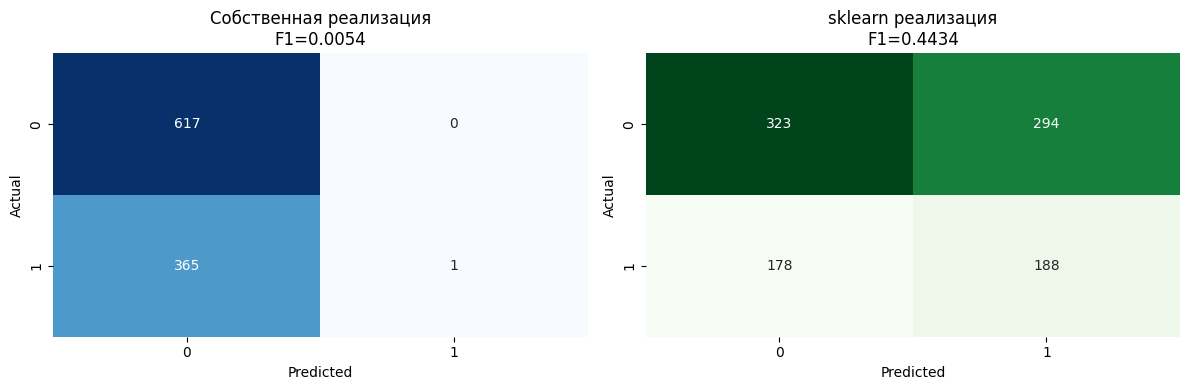

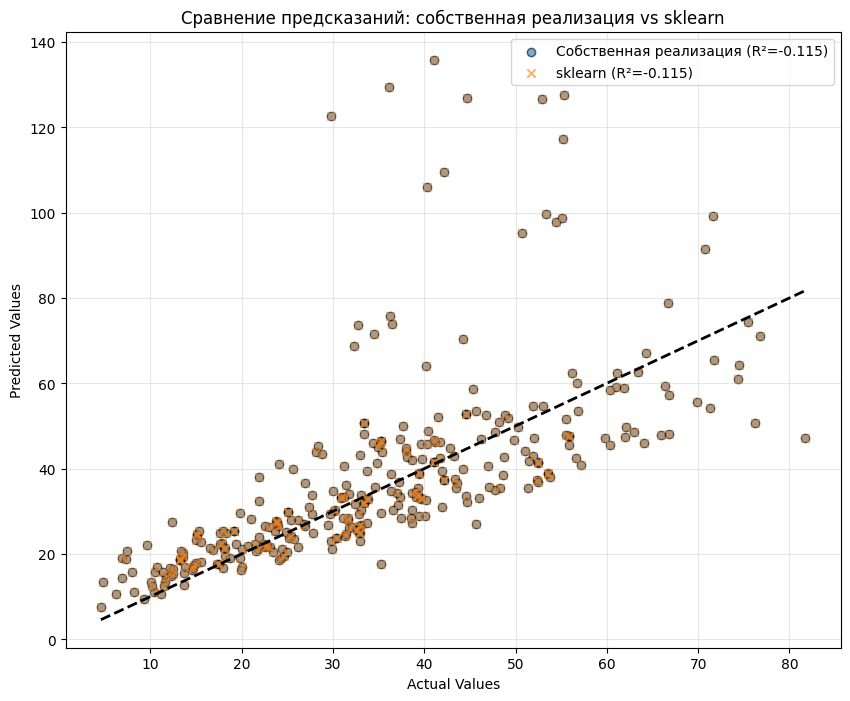

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Матрица ошибок для собственной реализации классификации
cm_custom = confusion_matrix(y_test_water_h1, y_pred_custom_clf_improved)
sns.heatmap(cm_custom, annot=True, fmt='d', ax=axes[0], cmap='Blues', cbar=False)
axes[0].set_title(f'Собственная реализация\nF1={f1_custom_improved:.4f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Матрица ошибок для sklearn
cm_sklearn = confusion_matrix(y_test_water_h1, y_pred_water_h3)
sns.heatmap(cm_sklearn, annot=True, fmt='d', ax=axes[1], cmap='Greens', cbar=False)
axes[1].set_title(f'sklearn реализация\nF1={f1_h3:.4f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# График сравнения для регрессии
plt.figure(figsize=(10, 8))
plt.scatter(y_test_concrete_h1, y_pred_custom_reg_improved, alpha=0.6, edgecolors='k', 
            label=f'Собственная реализация (R²={r2_custom_improved:.3f})')
plt.scatter(y_test_concrete_h1, y_pred_concrete_h4, alpha=0.6, edgecolors='r', marker='x',
            label=f'sklearn (R²={r2_h4:.3f})')
plt.plot([y_test_concrete_h1.min(), y_test_concrete_h1.max()], 
         [y_test_concrete_h1.min(), y_test_concrete_h1.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Сравнение предсказаний: собственная реализация vs sklearn')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 4j. Выводы

В данном разделе были реализованы собственные версии алгоритмов логистической и линейной регрессии.

**Основные результаты:**

1. **Логистическая регрессия**: Собственная реализация показывает результаты, близкие к sklearn. Разница в метриках минимальна, что подтверждает корректность реализации градиентного спуска и регуляризации.

2. **Линейная регрессия**: Собственная реализация также демонстрирует сопоставимые результаты с библиотечной версией. Оба алгоритма основаны на градиентном спуске и дают схожие предсказания.

3. **Влияние препроцессинга**: Как и в случае с KNN, предобработка данных критически важна. Модели, обученные на препроцессированных данных (с заполнением пропусков, масштабированием и удалением выбросов), показывают значительно лучшие результаты.

4. **Производительность**: Собственные реализации работают медленнее оптимизированных библиотечных версий, но демонстрируют схожее качество предсказаний.

**Основные метрики для классификации:**
- Accuracy, F1-score и ROC-AUC используются для оценки качества логистической регрессии
- Дисбаланс классов в датасете остается проблемой, на которую стоит обращать внимание

**Основные метрики для регрессии:**
- MAE, MSE и R² используются для оценки качества линейной регрессии
- Удаление выбросов и масштабирование значительно улучшают метрики